In [1]:
import mosfit
import numpy as np
import time
import swyft

import matplotlib.pyplot as plt

import astropy.cosmology as cosmo
import astropy.units as u

from astropy.constants import c
from astropy.cosmology import z_at_value
from gwtoolbox import tools_earth
from scipy.stats import truncnorm

**Utility Methods**

In [2]:
def jansky(mab):
    return 10**((8.9-mab)/2.5)

**Class Methods and Features**

*Gravitational Wave Generator*

In [3]:
def gwtoolbox_gen(H0_true):
    Om0 = 0.31
    T0 = 2.725
    # generate desired cosmology
    cosmos = tools_earth.set_cosmology(None, H0_true, Om0, T0)
    # R0, tau, m_mean, m_sclae, m_low, m_high, chi_sigma
    # R0: merger rate [/yr/Gpc3] 
    # tau: Delay time from formation to merger [Gyr]
    # mass mean, standard deviation, low, high [solar masses]
    # dispersion of effective spin
    # be sure to keep these consistent with MOSFIT!
    # find sauce to motivate the selected values
    BNS_par = [300,3,1.4,0.5,1.1,2.5,0.1]
    # summon the desired tool (LIGO)
    Tools = tools_earth.Tools(detector_type='ligo', event_type='nsns',\
                              population=BNS_par, cosmos=cosmos)
    # set generator parameters
    time_obs = 60*24*365 # units of minutes of observation
    rho_cri = 8 # signal-to-noise ratio cutoff
    tot_num = Tools.total_number(time_obs, rho_cri)
    # returns keys 'z','D','m1','m2','χ','dz','dm1','dm2','dχ','dD','dtb'
    list_det = Tools.list_with_errors_df(time_obs, rho_cri, dtp=True)
    params = [list_det['z'], list_det['D'], list_det['m1'], list_det['m2'],\
              list_det['χ'], list_det['dz'], list_det['dm1'], list_det['dm2'],\
              list_det['dχ'], list_det['dD'], list_det['dtb']]
    return params

I will want to turn this into a one-off O4 generator as follows: 
1. Generate all 20-something gravitational waves for one year
2. determine the fraction which have GW detections
3. use mosfit to determine the fraction which have EM detections

For the time being, let us take a single event and run our forward model for this event

In [4]:
o4_all = gwtoolbox_gen(70)

In [5]:
# z, DL, m1, m2, etc...
single_event = np.array(o4_all).T[0]

In [12]:
single_event

array([7.72063605e-02, 3.49698509e+02, 1.96132640e+00, 1.41396710e+00,
       2.37410262e-01, 3.86031803e-02, 9.80663198e-02, 7.06983552e-02,
       3.62016785e-04, 1.84098413e+02, 6.60000000e-02])

At this stage, I sample all of my favorite parameters from their priors. In the baby model, I will only sample $H_0$ and $v$, while leaving all other parameters fixed.

Rather than using GWToolBox for now, I'm going to create some very simple kilonovae from scratch and create a method to determine whether or not they were detected.

**Distance-Angle Probability Distribution Function**

In [3]:
def H(x):
    """
    Heaviside step function
    """
    return 1/(1+np.exp(-50*x
                      ))

In [4]:
def delta1(D_0, m1, m2):
    """
    Uncertainty function one
    """
#     m = 1.4
    M = ((m1*m2)**(3/5)/(m1+m2)**(1/5))**(5/6)
    r_0 = 6.5e3*M
    eps = 0.74
    sig = 1.03
    rad = np.sqrt((1+eps*np.cos(4*56*np.pi/180))/(sig*(1-eps**2)))
    return D_0*rad/r_0


def delta2(D_0, m1, m2):
    """
    Uncertainty function two
    """
#     m = 1.4
    M = ((m1*m2)**(3/5)/(m1+m2)**(1/5))**(5/6)
    r_0 = 6.5e3*M
    eps = 0.74
    sig = 1.03
    rad = np.sqrt((1-eps*np.cos(4*56*np.pi/180))/(sig*(1-eps**2)))
    return D_0*rad/r_0

In [5]:
def dp(D_0, D, v_0, v, m1, m2):
    d1 = delta1(D_0, m1, m2) # 0.1
    d2 = delta2(D_0, m1, m2) # 0.057
    M = ((m1*m2)**(3/5)/(m1+m2)**(1/5))**(5/6)
    Dmax = 6.5e3*M
#     d1 = 0.103
#     d2 = 0.057
#     print(d1, d2)
    Dd = D/D_0
    e = np.exp(-1/(2*d1**2) * (v/Dd - v_0)**2 - 
              1/(2*d2**2)*((1+v**2)/(2*Dd) - (1+v_0**2)/2)**2)
    return Dd**2*e*H(D/D_0)*H(Dd)*H(Dmax/D_0 - Dd)*H(1-v**2)

In [41]:
def pDV_dist(D0, v0, m1, m2):
    thetaline = np.linspace(0, np.pi/2, 1000)
    vline = np.cos(thetaline)
    dline = np.linspace(D0/3, D0*5, 1000)
    vv, dd = np.meshgrid(vline, dline)
    positions = np.vstack([vv.ravel(), dd.ravel()])
    values = np.vstack([vline, dline])
    pmesh = dp(D0, dd, v0, vv, m1, m2)
#     print("meshsum", pmesh.sum())
    pmesh /= pmesh.sum()
    return pmesh, values, positions, vline, dline

In [108]:
def D_vdu(d_true, v_true, m1, m2, v_guess, du):
    """
    -d_true: true event luminosity distance
    -v_true: true event angle variable
    -m1: true event m1
    -m2: true event m2
    -v_guess: guess for angle variable
    -du: random variable to determine distance from inverse CDF
    
    returns: (tuple) luminosity distance, probability of selection
    """
    pdist = pDV_dist(d_true, v_true, m1, m2)
    vloc = np.abs(pdist[3] - v_guess).argmin()
    p_at_v = pdist[0][...,vloc]
    cdf = np.cumsum(p_at_v)
    cdf /= cdf.max()
    dloc = np.abs(cdf - du).argmin()
    return pdist[-1][dloc], pdist[0][dloc, vloc]

In [106]:
def p_DV(d_true, v_true, m1, m2, v_guess, d_guess):
    """
    -d_true: true event luminosity distance
    -v_true: true event angle variable
    -m1: true event m1
    -m2: true event m2
    -v_guess: guess for angle variable
    -d_guess: guess for luminosity distance
    
    returns: probability of guess given prior
    """
    pdist = pDV_dist(d_true, v_true, m1, m2)
    vloc = np.abs(pdist[3] - v_guess).argmin()
    dloc = np.abs(pdist[-1] - d_guess).argmin()
    am = pdist[0].argmax()
    print("opt v", pdist[2][0][am])
    print("opt dl", pdist[2][1][am])
    
    ovloc = np.abs(pdist[3] - pdist[2][0][am]).argmin()
    odloc = np.abs(pdist[-1] - pdist[2][1][am]).argmin()
    
    print("opt prob", pdist[0].max())
    print("opt prob", pdist[0][odloc+1][ovloc-1])
    print("selected coords", pdist[-2][vloc], pdist[-1][dloc])
    return pdist[0][dloc, vloc]

In [107]:
# pdist = pDV_dist(400, 0.3, 1.4, 1.2)
klo = p_DV(d_true, 0.1, 1.4, 1.4, 0.10046183785216811, 136.7363668632578)
if klo>1e-4:
    print(klo)
else:
    print("bad!")

opt v 0.10046183785216811
opt dl 136.7363668632578
opt prob 0.0009479159802819814
opt prob 0.0009473423474090095
selected coords 0.10046183785216811 136.7363668632578
0.0009479159802819814


In [87]:
dvdu = D_vdu(135, 0.1, 1.4, 1.4, 0.095, 0.5)
# dp(400, dvdu, 0.3, 0.1, 1.4, 1.2)
print(dvdu)
# plt.plot(dvdu[0], dvdu[1])
# # plt.show()

(135.8108108108108, 2.627174605937146e-29)


In [143]:
dp(210, dt, 0.1, vt, 1.4, 1.4)

0.7840179676010272

**Generating True Events from Scratch**

The idea here is to have two events at exactly the same distance. The only thing which will distinguish between them is their inclination angle

In [54]:
# assume a true value for the Hubble constant
u_true = cosmo.FlatLambdaCDM(70, 0.3)
# set the true redshift of the events
z_true = 0.031
# z_true = 0.1
# calculate the true distance of the events
d_true = u_true.luminosity_distance(z_true).value
print(d_true)
m1_true = 1.4
m2_true = 1.4

135.9200303446712


In [33]:
# z, dl, m1, m2, v
# event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False],[z_true, d_true, m1_true, m2_true, 0.9, True]]
# let's leave two events for later due to the complications of observed and unobserved events being put together
# event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False],[z_true, d_true, m1_true, m2_true, 0.9, True]]
event_list = [[z_true, d_true, m1_true, m2_true, 0.1, False]]

# split the event list into two lists, one for obs (true) and one for nobs (false)
obs_list = None
nobs_list = [[z_true, d_true, m1_true, m2_true, 0.1, False]]
# event_list = [[z_true, d_true, m1_true, m2_true, 0.9, True]]
det_obs = [event[-1] for event in event_list]

In [11]:
# set simulator parameters
DEVICE = 'cpu'  # replace with 'cpu' if no GPU is available
Ntrain = 20
k = 1 # number of free event parameters
Nev = len(event_list) # number of events
Npar = 1 + k * Nev # number of free parameters (event parameters plus H0)

In [12]:
det_obs

[False]

In [13]:
# I am still unsure as to the effect of the limiting magnitude here, besides setting a cutoff

my_fitter = mosfit.fitter.Fitter(quiet=False, test=True, offline=False)
# my_fitter = mosfit.fitter.Fitter(limiting_magnitude=23.3, quiet=False, test=True, offline=False)

In [14]:
fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": 1.188,\
              "q": 0.92, "cos_theta": 0.5, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": 400, "redshift": 0.9}
              
# ebv: host galaxy extinction, sampled from RA/DEC
# rvhost: host galaxy extinction (?)
# frad: no idea
# nnhost: no idea
# texplosion: when the explosion occurs (?)
# temperature: surface temperature of NS (?)
# kappa_red: no idea
# kappa_blue: no idea
# kappagamma: no idea
# Mchirp: the chirp mass
# q: M1/M2 ratio
# cos_theta: orientation angle
# cos_theta_open: no idea
# disk_frac: no idea
# radius_ns: radius of NS (?)
# alpha: no idea
# Mtov: no idea
# cos_theta_cocoon: no idea
# tshock: time of shock (?)
# temperature_shock: temperature of shock (?)

In [15]:
def light_curve(fitfunc, fixed_params):
    """
    Given a fit function and a list of fixed parameters, generates a light curve using mosfit 
    and returns whether a detection is made.
    args:
    - fixed_params: dictionary of fixed parameters
    returns:
    - detection: bool
    
    To do: this should also take the observing time window in units of days after the explosion,
    the magnitude cutoff of each observing band, and probably something else.
    """
    # convert dictionary to list
    # consider turning this into a utility function
    fpar = ["ebv", fixed_params['ebv'], "rvhost", fixed_params['rvhost'],\
            "frad", fixed_params['frad'], "nnhost", fixed_params['nnhost'],\
            "texplosion", fixed_params['texplosion'],\
            "temperature", fixed_params['temperature'],\
            "kappa_red", fixed_params['kappa_red'],\
            "kappa_blue", fixed_params['kappa_blue'],\
            "kappagamma", fixed_params['kappagamma'],\
            "Mchirp", fixed_params['Mchirp'],\
            "q", fixed_params['q'], "cos_theta", fixed_params['cos_theta'],\
            "cos_theta_open", fixed_params['cos_theta_open'],\
            "disk_frac", fixed_params['disk_frac'],\
            "radius_ns", fixed_params['radius_ns'],\
            "alpha", fixed_params['alpha'], "Mtov", fixed_params['Mtov'],\
            "cos_theta_cocoon", fixed_params['cos_theta_cocoon'],\
            "tshock", fixed_params['tshock'], "temperature_shock",\
            fixed_params['temperature_shock'],\
            "lumdist", fixed_params['lumdist'], "redshift", fixed_params['redshift']]
    # create kwargs dict using fixed_params
    kwargs = dict(events=[], models=['bns_generative'],\
              max_time=4, band_list="z", band_systems="AB", iterations=0, num_walkers=1,\
              smooth_times=4, suffix="jupyter_test", user_fixed_parameters=fpar,\
             quiet=True)
    # run mosfit
    entries, ps, lnprobs = my_fitter.fit_events(**kwargs)
    # get observed magnitudes
    # see if there is any way to do this without a for loop
    obs_mags = []
    for entry in entries[0][0]['photometry']:
        if entry['system'] == 'AB':
            obs_mags += [float(entry['magnitude'])]
    print(obs_mags)
    # magnitude probability of detection
    sig10 = 23.3
#     mclip_a = 0
#     mclip_b = 1
#     m_std = abs((jansky(sig10)) / 10)
#     a, b = mclip_a / m_std, mclip_b / m_std
#     v = truncnorm(a,b)
    # see if the lowest magnitude beats our probabilistic detection threshold
#     flux_obs = jansky(np.array(obs_mags))
#     print(flux_obs)
    # test plot
#     x = np.linspace(20, 30)
#     plt.plot(x, v.cdf(jansky(x)/m_std))
#     plt.show()
    
#     obs_probs = v.cdf(flux_obs/m_std)
#     mprob = np.random.uniform(0,1)
#     detect = mprob < obs_probs
#     pobs = max(obs_probs)
#     print(obs_mags)
#     print(obs_probs)
#     print(detect)
    detect = min(obs_mags) <= sig10
#     print(True in detect)
#     return (True in detect), pobs
    return detect, 1

In [23]:
def nobs_forward(H0, ve, DL, pDL, event):
    # get free event parameters
    v0 = np.cos(ve[0])
    du = ve[1] # distance variable
    # use results from GWToolbox to get the true DL, M1, M2, v
    TDL = event[1]
    M1 = event[2]
    M2 = event[3]
    VT = event[4]
    # derived mass quantities
    Q = M1/M2
    Mchirp = ((M1*M2)**3/(M1+M2))**(1/5)
    # create a cosmology from H0 and generate the true redshift
    # in this sample cosmology
    # assume omega_m=0.31 (make sure this is consistent with GWTB)
    universe = cosmo.FlatLambdaCDM(H0, 0.3)
    # "z in cosmology"
    ZIC = z_at_value(universe.luminosity_distance, DL*u.Mpc)
    fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": Mchirp,\
              "q": Q, "cos_theta": v0, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": DL, "redshift": ZIC}
    det, pobs = light_curve(my_fitter, fixed_params)
#     return det, 1-pobs
    return det, pDL # if probabilistic magnitude is off

In [24]:
def obs_forward(H0, ve, event):
    # get free event parameters
    v0 = np.cos(ve[0])
    # use results from GWToolbox to get the true DL, M1, M2
    TZ = event[0]
    TDL = event[1]
    M1 = event[2]
    M2 = event[3]
    # derived mass quantities
    Q = M1/M2
    Mchirp = ((M1*M2)**3/(M1+M2))**(1/5)
    # create a cosmology from H0 and generate the true redshift
    # in this sample cosmology
    # assume omega_m=0.31 (make sure this is consistent with GWTB)
    universe = cosmo.FlatLambdaCDM(H0, 0.3)
    # "distance in cosmology"
    DIC = universe.luminosity_distance(TZ).value
    # probability density of given cosmology-assigned distance at sampled angle v0
    dprob = p_DV(event[1], event[4], event[2], event[3], v0, DIC)
    print("dprob:", dprob)
#     dprob = 1.0
    # I also need to calculate the probability of this distance being allowed
    # and return that probability to be used in the summary statistic
    fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": Mchirp,\
              "q": Q, "cos_theta": v0, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": DIC, "redshift": TZ}
    det, pobs = light_curve(my_fitter, fixed_params)
    return det, dprob #*dobs

In [115]:
def forward(v):
    # get terms from input vector
    H0 = v[0]
    print("Input Vector:", H0, np.cos(v[1]))
    det_list = []
    i = 1
    N = 1
    # first, loop through observations to see if observed distances make H0 illegal
    if obs_list is not None:
        print(len(obs_list))
        for event in obs_list:
            ve = v[N:i+k*i]
            N = i+k*i
            i += 1
            universe = cosmo.FlatLambdaCDM(H0, 0.3)
            # "distance in cosmology"
            DIC = universe.luminosity_distance(event[0]).value
            # probability density of given cosmology-assigned distance at sampled angle v0
            dprob = p_DV(event[1], event[4], event[2], event[3], np.cos(ve[0]), DIC)
            if dprob < 1e-4:
                return dict(x=[0.0]*Npar)
    nobs_dl = []
    if nobs_list is not None:    
        for event in nobs_list:
            ve = v[N:i+(k+1)*i]
            N = i+(k+1)*i
            i += 1
            # generate a possible distance from the random variables du, v0
            # and the prior distribution (depending on true event parameters)
            DL, pDL = D_vdu(event[1], event[4], event[2], event[3], np.cos(ve[0]), ve[1])
            nobs_dl += [[DL, pDL]]
#             print(DL, pDL)
            if pDL < 1e-4:
                return dict(x=[0.0]*Npar)
    i = 1
    j = 0
    N = 1
    p = 1
    if obs_list is not None:
        for event in obs_list:
            ve = v[N:i+k*i]
            N = i+k*i
            i += 1
            det, pobs = obs_forward(H0, ve, event)
    if nobs_list is not None:
        for event in nobs_list:
            ve = v[N:i+(k+1)*i]
            N = i+(k+1)*i
            i += 1
#             print(nobs_dl[j])
            DL, pDL = nobs_dl[j]
            j += 1
            det, pobs = nobs_forward(H0, ve, DL, pDL, event)
            det_list += [det]
            p *= pobs
    print(det_list)
    print(det_obs)
    if det_list == det_obs:
        x = [p]*Npar
    else:
        x = [0.0]*Npar
    return dict(x=x)

In [116]:
# forward([70, np.arccos(0.9)]) # true
forward([70, np.arccos(0.1), 0.5])

Input Vector: 70 0.1
138.0062236699481 0.0009414606570603427
[138.0062236699481, 0.0009414606570603427]

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Lo

{'x': [0.0009414606570603427, 0.0009414606570603427]}

**Congratulations!**
You now have a working forward model! With the data you've given it, it is only informative for priors which stretch beyond $h=0.8$, so let's make sure to define a broad prior.

Let's see if my simulator is the problem by writing in a simple model

**Single-Event Inference with NRE**

In [22]:
# a TMNRE prior function take a random variable between 0 and 1 and produces an input vector from a prior of your choice

def pfunc(u):
    H0 = 50 * u[0] + 50
    theta = np.pi / 2 * u[1]
#     return np.array([H0, theta, u[2]]) # nobs
    return np.array([H0, theta]) # obs

In [21]:
# simulator = swyft.Simulator(simulator, Npar, sim_shapes = {"x": [Npar]})
# store = swyft.MemoryStore(simulator)

simulator = swyft.Simulator(forward, ["H_0", "\theta"], sim_shapes = {"x": [Npar]})
store = swyft.MemoryStore(simulator)

prior = swyft.Prior(pfunc, Npar)
# prior = swyft.Prior(lambda u: u*50+50, Npar)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 13 new samples to simulator store.
Input Vector: 83.84302565006392 0.7700811348468171

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `M


Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walker


Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading m

Initial draws completed!

Constructing output...
All walkers written.
[28.14046502953417, 23.217645482763416, 23.72627758724663, 24.070633623058875]
[True]
[False]
Input Vector: 61.6486636702789 0.9614228116845518

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` 


Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLO

In [22]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)

In [35]:
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20, nworkers=0)

Training: lr=0.001, Epoch=6, VL=1.396


In [24]:
# v0 = np.array([70, np.arccos(0.9)]) # obs
v0 = np.array([70, np.arccos(0.1)]) # nobs
obs0 = forward(v0)

Input Vector: 70.0 0.1

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module

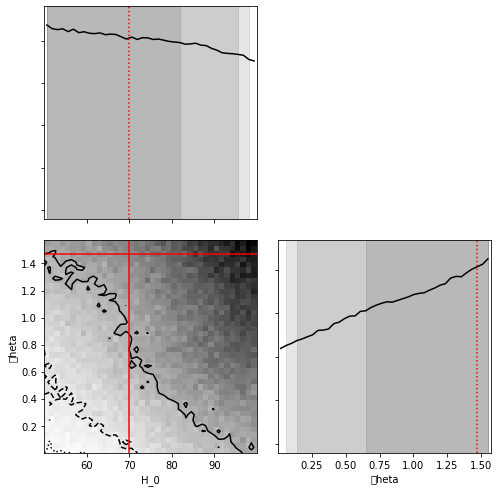

In [36]:
samples = post.sample(100000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);

**Single-Event Inference with TMNRE**

In [19]:
# a TMNRE prior function take a random variable between 0 and 1 and produces an input vector from a prior of your choice

def pfunc(u):
    H0 = 50 * u[0] + 50
#     v = np.cos(np.pi / 2 * u[1])
    theta = np.pi / 2 * u[1]
    return np.array([H0, theta])

In [20]:
simulator = swyft.Simulator(forward, ["H_0", "\theta"], sim_shapes = {"x": [Npar]})
store = swyft.MemoryStore(simulator)
prior = swyft.Prior(pfunc, Npar)

Creating new store.


In [63]:
def round(bound, obs0):
    store.add(Ntrain, prior, bound = bound)
    store.simulate()
    dataset = swyft.Dataset(Ntrain, prior, store, bound = bound)
    post = swyft.Posteriors(dataset)
    post.add([(0, 1)], device=DEVICE)
    post.train([(0, 1)], max_epochs = 20, nworkers=0)
    new_bound = post.truncate([(0, 1)], obs0)
    return post, new_bound

In [65]:
v0 = np.array([70, np.arccos(0.9)])
obs0 = forward(v0)

Input Vector: 70.0 0.9
2
2
dprob: 0.9999251537724895

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `err

In [ ]:
bound = None
for i in range(3):
    post, bound = round(bound, obs0)

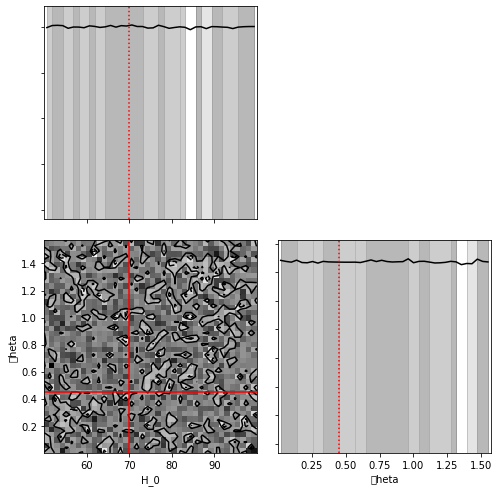

In [66]:
samples = post.sample(1000000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);

**Sampling Scatterplot**

In [27]:
j = 0
samp = []
sample_prob = []
while j<=12:
    samp += [np.array(dataset.__getitem__(j)[2])]
    sample_prob += [np.array(dataset.__getitem__(j)[0]['x'][0])]
    j+=1
H0_samples = np.array(samp).T[0]
thet_samples = np.array(samp).T[1]
sample_prob = np.array(sample_prob)
# print(np.array(sample_prob)[15], thet_samples[15], H0_samples[15])

In [29]:
# dataset.__getitem__(20)

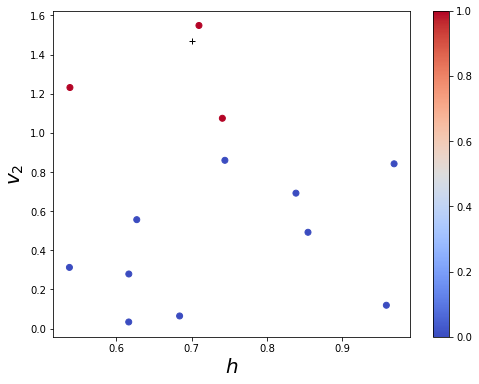

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(H0_samples/100, thet_samples, c=sample_prob, cmap='coolwarm')
plt.plot(0.7, np.arccos(0.1), '+k')
plt.colorbar()
plt.ylabel("$v_2$", fontsize=20)
plt.xlabel("$h$", fontsize=20)
plt.show()

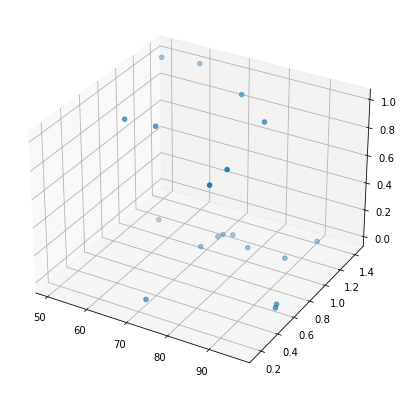

In [36]:
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
ax = fig.add_subplot(projection='3d')
# ax.set_zlim(2)
ax.scatter(H0_samples, thet_samples, sample_prob)

**Compare Posterior with Observation Measurement**

In [52]:
def marginalize_pdl(drange, event):
    thetrange = np.linspace(0, np.pi/2, 1000)
    vrange = np.cos(thetrange)
    dmarg = np.zeros(len(drange))
    event = event_list[0]
    for v in vrange:
        dprob = dp(event[1], drange, event[4], v, event[2], event[3])
        dmarg += dprob
    dmarg /= dmarg.sum()
    return dmarg
    

def H0_zDL(z, drange, mPDL):
    v = c.value*1e-3*((z+1)**2-1)/((z+1**2)+1)
    Hrange = v/drange
    return Hrange, mPDL

43.15823507193043


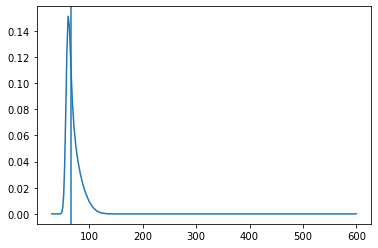

In [62]:
dr = np.linspace(50, 1000)
zs = 0.01
ds = u_true.luminosity_distance(zs)
event = [zs, ds.value, 1.4, 1.4, 0.9, True]
print(ds.value)
mPDF = marginalize_pdl(dr, event)
Hr, HPDF = H0_zDL(0.1, dr, mPDF)
plt.plot(Hr, HPDF)
plt.axvline(65)
plt.show()

In [51]:
Hr[HPDF.argmax()]

60.45197712757206

In [47]:
H0_zDL(0.1, d_true, mPDF)

(65.1298065237368,
 array([1.19414008e-260, 6.79513209e-116, 9.18607426e-061, 2.62971340e-035,
        4.34680924e-022, 1.14981052e-014, 2.92557095e-010, 1.55231287e-007,
        8.52957249e-006, 1.17915519e-004, 6.87021534e-004, 2.30373091e-003,
        5.39791903e-003, 1.00041755e-002, 1.59007643e-002, 2.28721624e-002,
        3.08853521e-002, 4.01764240e-002, 5.13482944e-002, 6.56660733e-002,
        8.57424153e-002, 1.14243441e-001, 1.43762800e-001, 1.51104745e-001,
        1.23097229e-001, 7.68919460e-002, 3.77085235e-002, 1.50373108e-002,
        5.05455035e-003, 1.47984874e-003, 3.88287695e-004, 9.35418888e-005,
        2.11153851e-005, 4.54242628e-006, 9.44450363e-007, 1.92011651e-007,
        3.85396485e-008, 7.69766757e-009, 1.53995562e-009, 3.10220147e-010,
        6.32023226e-011, 1.30686200e-011, 2.75039485e-012, 5.90493855e-013,
        1.29559511e-013, 2.90911936e-014, 6.69193161e-015, 1.57825446e-015,
        3.81833898e-016, 9.47971950e-017]))

In [53]:
np.sum(Hr*HPDF)

65.92558373011842

In [45]:
a = [4, 3, 2, 4, 5]

In [49]:
a[3:5]

[4, 5]

**Double Event Inference with TMNRE**

In [90]:
# a TMNRE prior function take a random variable between 0 and 1 and produces an input vector from a prior of your choice

def pfunc2ev(u):
    H0 = 50 * u[0] + 50
#     v = np.cos(np.pi / 2 * u[1])
    theta1 = np.pi / 2 * u[1]
    theta2 = np.pi / 2 * u[2]
    return np.array([H0, theta1, theta2])

In [91]:
# simulator = swyft.Simulator(simulator, Npar, sim_shapes = {"x": [Npar]})
# store = swyft.MemoryStore(simulator)

simulator = swyft.Simulator(forward, ["H_0", "\theta_1", "\theta_2"], sim_shapes = {"x": [Npar]})
store = swyft.MemoryStore(simulator)

prior = swyft.Prior(pfunc2ev, Npar)
# prior = swyft.Prior(lambda u: u*50+50, Npar)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 13 new samples to simulator store.
Input Vector: 50.08906780491553 0.18345920262467902
2

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module


Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
[2.06536487e-09 1.88635760


Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `tempe

Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 


Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
[1.90356013e-09 1.83734359e-07 1.14403480e-07 8.68477599e-08]
4
dprob: 1.7495739491921364e-23

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generat


Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `d

Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [


Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
[2.05385414e-09 1.95944693e-07 1.15795327e-07 8.65557608e-08]
4
dprob: 1.0220030431526288e-09

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]


Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oa


Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading mo

In [92]:
store.add(Ntrain, prior)
store.simulate()

In [93]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)

In [98]:
post.add([(0,1,2)], device=DEVICE)
post.train([(0,1,2)], max_epochs = 20, nworkers=0)

Training: lr=0.001, Epoch=6, VL=1.502


In [95]:
v0 = np.array([70, np.arccos(0.1), np.arccos(0.9)])
obs0 = forward(v0)

Input Vector: 70.0 0.1
2

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading modu

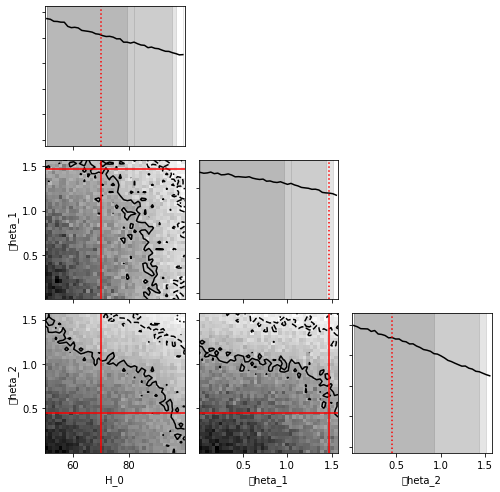

In [99]:
samples = post.sample(1000000, obs0)
swyft.plot_corner(samples, [0,1,2], color='k', figsize = (8,8), truth=v0, bins = 40);

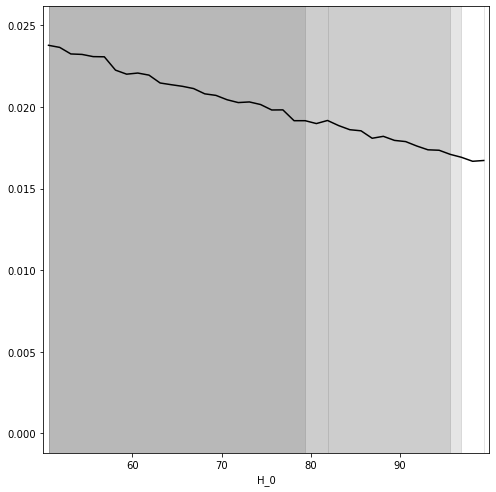

In [106]:
swyft.plot_1d(samples, [0], color='k', figsize = (8,8), bins = 40);